In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import sys
import os

sys.path.append(os.getcwd())
sys.path.append(os.getcwd()+"/split_step_fourier.py")

import split_step_fourier

# showing figures inline
%matplotlib inline
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

Text(0.5, 1.0, 'Impulse Responses')

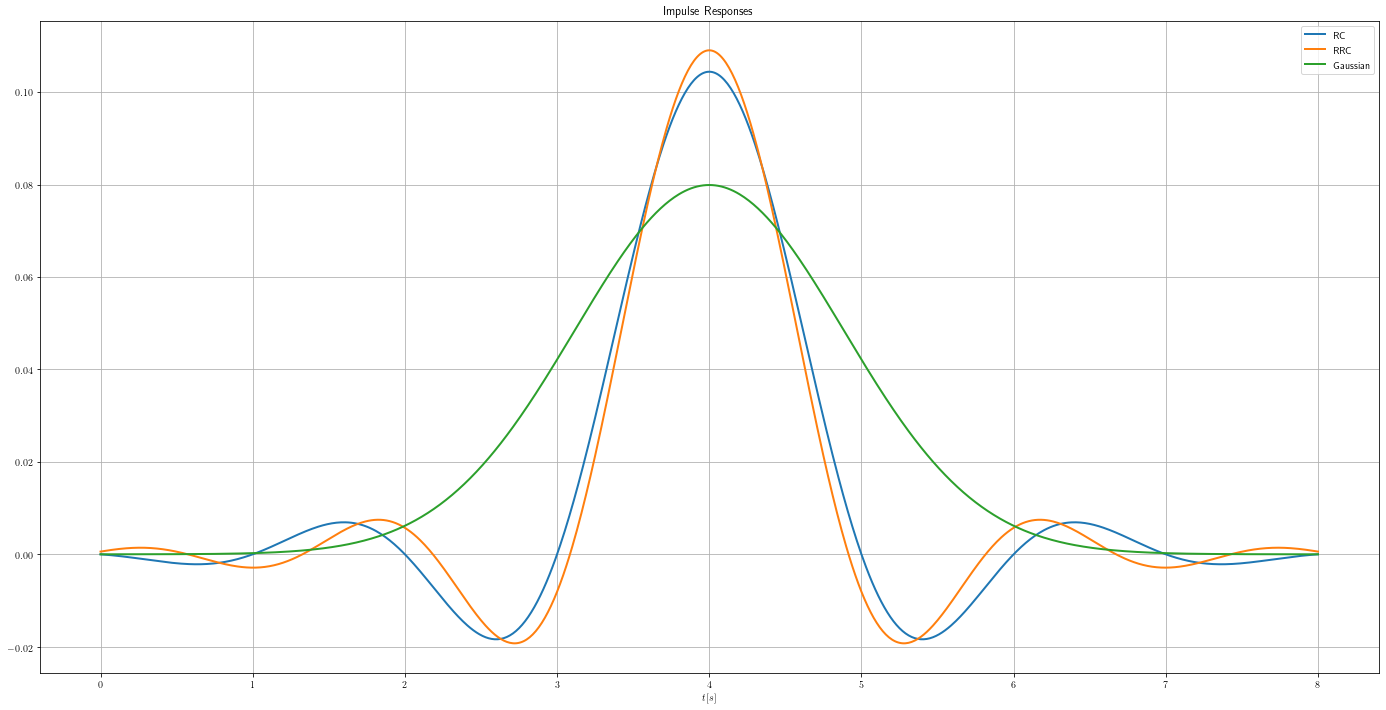

In [2]:
# parameters of the filters
f_symbol = 1.0  # sample rate (Baud)
n_up = 100 # samples per symbol (>1 => oversampling)

r_rc = .33
r_rrc = .33
r_gaussian = 0.8

syms_per_filt = 4  # symbols per filter (plus minus in both directions)

t_sample_rc, rc = split_step_fourier.get_rc_ir( syms_per_filt, r_rc, f_symbol, n_up )
t_sample_rrc, rrc = split_step_fourier.get_rrc_ir( syms_per_filt, r_rrc, f_symbol, n_up )
t_sample_gaussian, gaussian = split_step_fourier.get_gaussian_ir( syms_per_filt, r_gaussian, f_symbol, n_up )

matplotlib.rc('figure', figsize=(24, 12) )

plt.plot( np.arange(rc.size)*t_sample_rc, rc, linewidth=2.0, label='RC' )
plt.plot( np.arange(rc.size)*t_sample_rrc, rrc, linewidth=2.0, label='RRC' )
plt.plot( np.arange(rc.size)*t_sample_gaussian, gaussian, linewidth=2.0, label='Gaussian' )

plt.grid( True )
plt.legend( loc='upper right' )
plt.xlabel('$t[s]$')
plt.title( 'Impulse Responses' )

Text(0.5, 1.0, 'Impulse Responses')

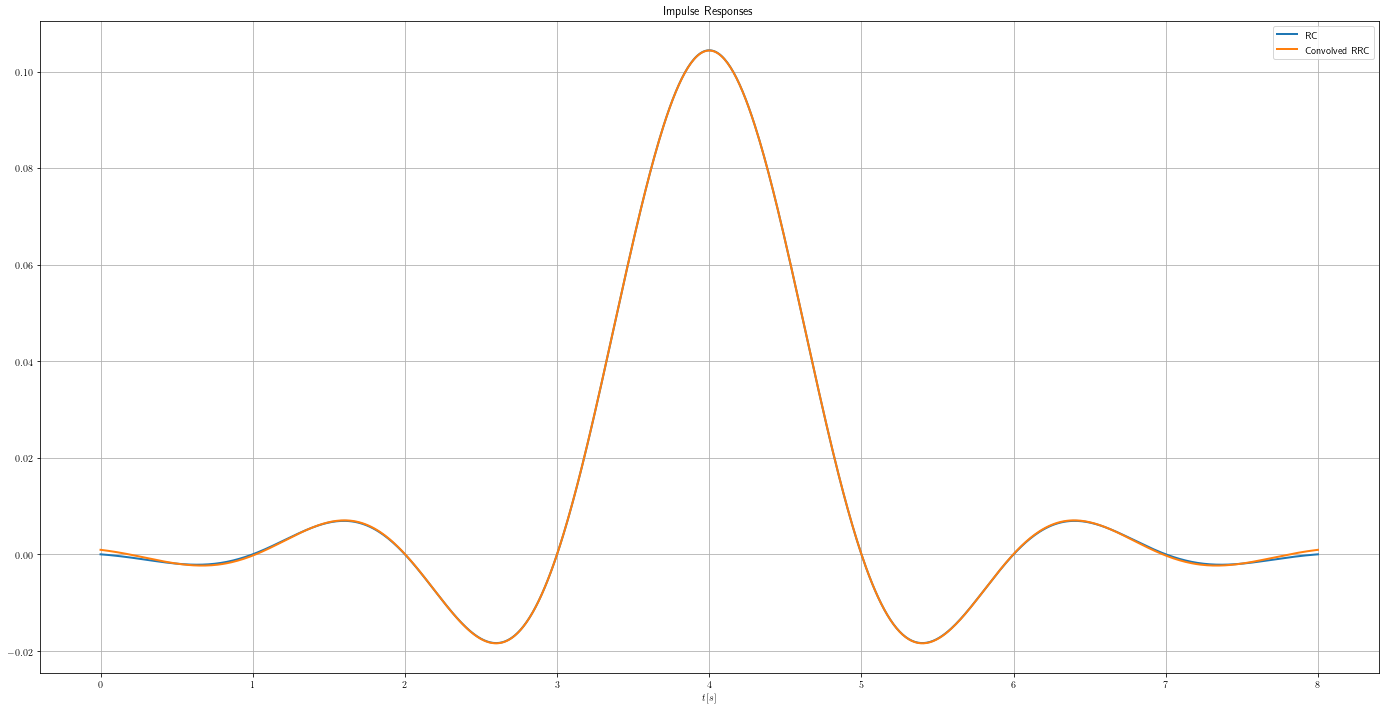

In [3]:
# Comparison of convolved rrc with rc

t_rc, rc = split_step_fourier.get_rc_ir( syms_per_filt, r_rc, f_symbol, n_up )
t_rrc, rrc = split_step_fourier.get_rrc_ir( syms_per_filt, r_rrc, f_symbol, n_up )

rrc_convolved = np.convolve(rrc, rrc, mode='same')
rrc_convolved /= np.linalg.norm(rrc_convolved)

matplotlib.rc('figure', figsize=(24, 12) )

plt.plot( np.arange(rc.size)*t_sample_rc, rc , linewidth=2.0, label='RC' )
plt.plot( np.arange(rrc_convolved.size)*t_sample_rrc, rrc_convolved, linewidth=2.0, label='Convolved RRC')

plt.grid( True )
plt.legend( loc='upper right' )
plt.xlabel('$t[s]$')
plt.title( 'Impulse Responses' )


Text(0.5, 1.0, 'Modulation Gaus')

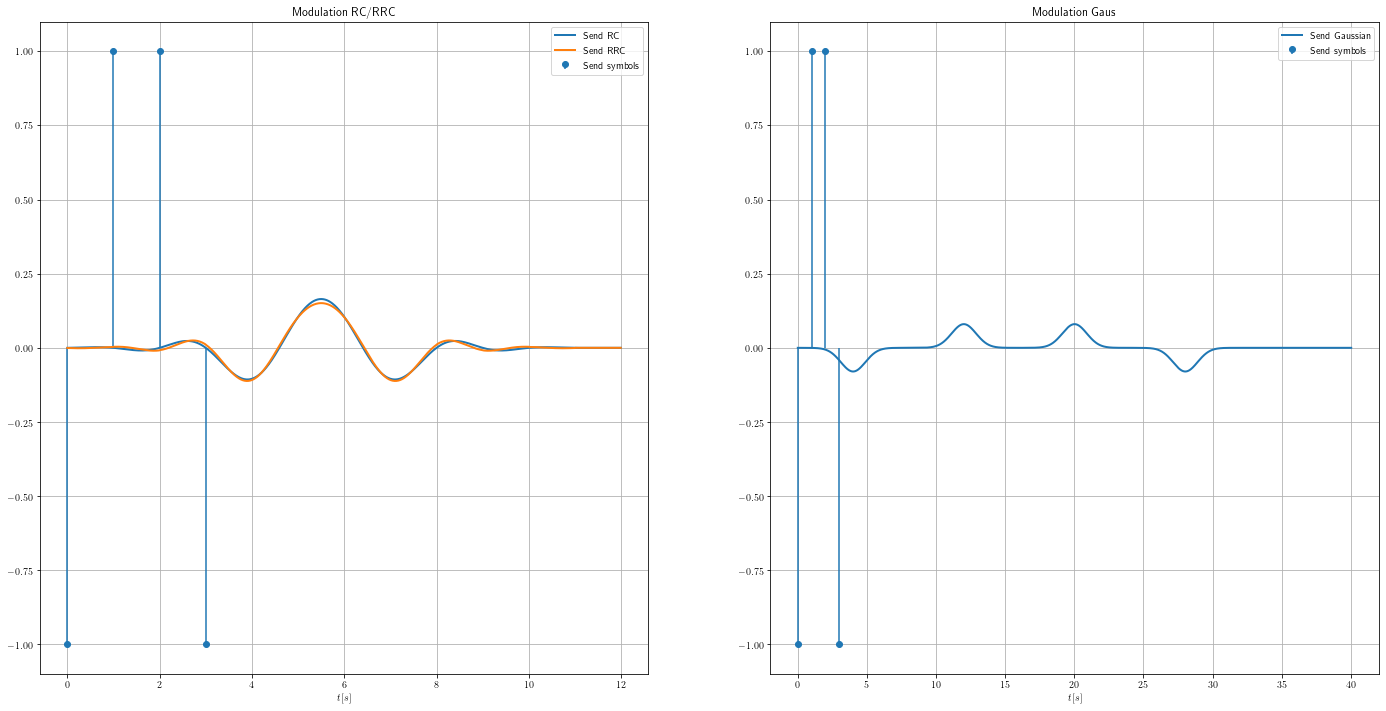

In [4]:
# modulation scheme and constellation points
M = 2
modulation = {'0': -1, '1': 1}

n_symbol = 4  # number of symbols

# Signalfolge generieren
send_bits = np.random.choice([symbol for symbol in modulation.keys()], size=n_symbol)

send_rc = split_step_fourier.generate_signal(modulation, send_bits, rc, syms_per_filt)
send_rrc = split_step_fourier.generate_signal(modulation, send_bits, rrc, syms_per_filt)
send_gaussian = split_step_fourier.generate_signal(modulation, send_bits, gaussian, 0)

matplotlib.rc('figure', figsize=(24, 12) )

plt.subplot(121)
plt.plot( np.arange(send_rc.size)*t_sample_rc, send_rc, linewidth=2.0, label='Send RC' )
plt.plot( np.arange(send_rrc.size)*t_sample_rrc, send_rrc, linewidth=2.0, label='Send RRC' )
plt.stem( np.arange(n_symbol*n_up, step=n_up)*t_sample_rc, [ modulation[str(symbol)] for symbol in send_bits ], label='Send symbols', use_line_collection=True, basefmt=' ')

plt.grid( True )
plt.ylim(-1.1, 1.1)
plt.xlabel('$t[s]$')
plt.legend( loc='upper right' )
plt.title( 'Modulation RC/RRC' )

plt.subplot(122)
plt.plot( np.arange(send_gaussian.size)*t_sample_gaussian, send_gaussian, linewidth=2.0, label='Send Gaussian' )
plt.stem( np.arange(n_symbol*n_up, step=n_up)*t_sample_gaussian, [ modulation[str(symbol)] for symbol in send_bits ], label='Send symbols', use_line_collection=True, basefmt=' ')

plt.grid( True )
plt.ylim(-1.1, 1.1)
plt.xlabel('$t[s]$')
plt.legend( loc='upper right' )
plt.title( 'Modulation Gaus' )


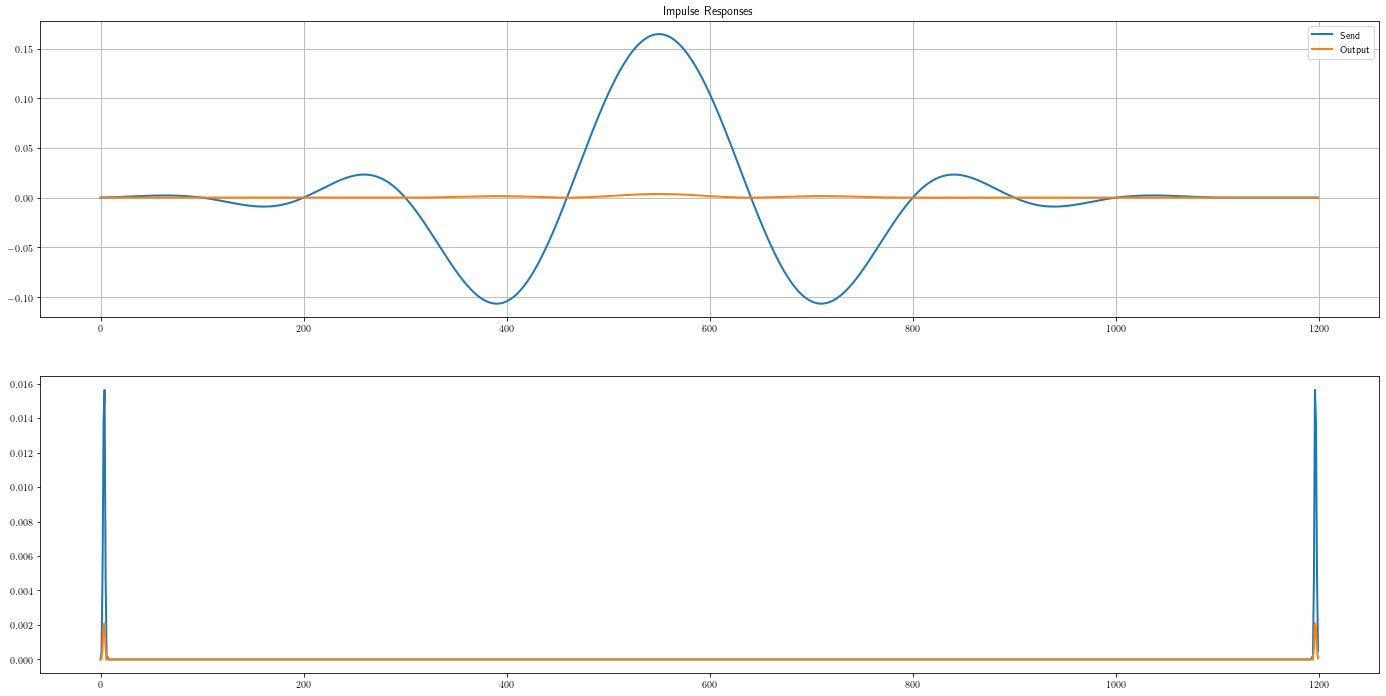

In [17]:
# Transmission

z_length = 10
nz = 10000
dz = z_length / nz

alpha=0.2  # Dämpfung (dB/km)
D = 17  # ps/nm/km
beta2 = -np.square(1550e-9) * ( D * 1e-6 ) / ( 2 * np.pi * 3e8)  # propagation constant
gamma = 0.5e-6 # ps/km

output = split_step_fourier.splitstepfourier(send_rc, t_sample_gaussian, dz, nz, alpha, beta2, gamma)

matplotlib.rc('figure', figsize=(24, 12) )

plt.subplot(211)
plt.plot( send_rc, linewidth=2.0, label='Send' )
plt.plot( np.square(abs(output)), linewidth=2.0, label='Output')

plt.grid( True )
plt.legend( loc='upper right' )
plt.title( 'Impulse Responses' )

plt.subplot(212)
plt.plot( np.square(abs(t_sample_gaussian*np.fft.fft(send_rc)/np.sqrt(2*np.pi))), linewidth=2.0, label='Send' )
plt.plot( np.square(abs(t_sample_gaussian*np.fft.fft(output)/np.sqrt(2*np.pi))), linewidth=2.0, label='Output')